In [ ]:
import pandas as pd
import numpy as np
import torch
import transformers
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load Dataset
df = pd.read_csv("/content/drive/MyDrive/Thesis/bully_not_bully_dataset.csv")
df = df.dropna()

In [ ]:
df.describe()

,comment,Category,Gender,label,bully_label
count,44001,44001,44001,44001,44001
unique,43567,5,2,5,2
top,নাস্তিক,Actor,Female,not bully,bully
freq,4,26951,29950,15340,28661


In [ ]:
def preprocess_text(text):

    text = text.replace("\n", " ")
    text = text.strip()
    return text

In [ ]:
df.isna().sum() # Checking for any missing values

,0
comment,0
Category,0
Gender,0
label,0
bully_label,0


In [ ]:
df["comment"] = df["comment"].apply(preprocess_text)

In [ ]:
# Replace string values with numerical equivalents before conversion
label_mapping = {'bully': 1, 'not bully': 0}  # Assuming 'bully' and 'not bully' are the categories
df['bully_label'] = df['bully_label'].map(label_mapping)

# Now, convert the column to integers
df['bully_label'] = df['bully_label'].astype(int)

In [ ]:
# Splitting dataset into train and test
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["comment"].tolist(), df["bully_label"].tolist(), test_size=0.2, random_state=42
)


In [ ]:

# Load DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

class BanglaDataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:

# Create dataset objects
train_dataset = BanglaDataset(train_texts, train_labels, tokenizer)
val_dataset = BanglaDataset(val_texts, val_labels, tokenizer)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:

# Load pre-trained DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
criterion = torch.nn.CrossEntropyLoss()


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:

# Training function with early stopping based on 3 consecutive worse epochs
def train_model(model, train_loader, val_loader, epochs=5, patience=3):
    """
    Train the DistilBERT model with tqdm progress bar and track training/validation metrics.
    Implements early stopping if validation loss increases or accuracy decreases for 3 consecutive epochs.
    """
    best_val_loss = float('inf')
    best_val_accuracy = 0
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(train_loader)
        train_accuracy = correct / total

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                logits = outputs.logits

                val_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_avg_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total

        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Train Accuracy = {train_accuracy:.4f}, Val Loss = {val_avg_loss:.4f}, Val Accuracy = {val_accuracy:.4f}")

        # Early stopping condition for 3 consecutive worse epochs
        if val_avg_loss > best_val_loss and val_accuracy < best_val_accuracy:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered due to worsening validation performance for 3 consecutive epochs!")
                break
        else:
            best_val_loss = min(best_val_loss, val_avg_loss)
            best_val_accuracy = max(best_val_accuracy, val_accuracy)
            patience_counter = 0

    return model

In [ ]:
# Train the model
model = train_model(model, train_loader, val_loader, epochs=15)

Epoch 1/15: 100%|██████████| 2200/2200 [06:40<00:00,  5.49it/s, loss=0.263]


Epoch 1: Train Loss = 0.4222, Train Accuracy = 0.7964, Val Loss = 0.3256, Val Accuracy = 0.8517


Epoch 2/15: 100%|██████████| 2200/2200 [06:35<00:00,  5.56it/s, loss=0.227]


Epoch 2: Train Loss = 0.3121, Train Accuracy = 0.8593, Val Loss = 0.3166, Val Accuracy = 0.8633


Epoch 3/15: 100%|██████████| 2200/2200 [06:35<00:00,  5.56it/s, loss=0.304]


Epoch 3: Train Loss = 0.2700, Train Accuracy = 0.8799, Val Loss = 0.3221, Val Accuracy = 0.8641


Epoch 4/15: 100%|██████████| 2200/2200 [06:35<00:00,  5.56it/s, loss=0.307]


Epoch 4: Train Loss = 0.2422, Train Accuracy = 0.8934, Val Loss = 0.2925, Val Accuracy = 0.8762


Epoch 5/15: 100%|██████████| 2200/2200 [06:35<00:00,  5.56it/s, loss=0.23]


Epoch 5: Train Loss = 0.2167, Train Accuracy = 0.9059, Val Loss = 0.2968, Val Accuracy = 0.8806


Epoch 6/15: 100%|██████████| 2200/2200 [06:36<00:00,  5.55it/s, loss=0.261]


Epoch 6: Train Loss = 0.1936, Train Accuracy = 0.9185, Val Loss = 0.2918, Val Accuracy = 0.8815


Epoch 7/15: 100%|██████████| 2200/2200 [06:36<00:00,  5.55it/s, loss=0.208]


Epoch 7: Train Loss = 0.1705, Train Accuracy = 0.9284, Val Loss = 0.3097, Val Accuracy = 0.8749


Epoch 8/15: 100%|██████████| 2200/2200 [06:36<00:00,  5.55it/s, loss=0.071]


Epoch 8: Train Loss = 0.1486, Train Accuracy = 0.9397, Val Loss = 0.3519, Val Accuracy = 0.8746


Epoch 9/15: 100%|██████████| 2200/2200 [06:36<00:00,  5.55it/s, loss=0.0459]


Epoch 9: Train Loss = 0.1311, Train Accuracy = 0.9470, Val Loss = 0.3906, Val Accuracy = 0.8774
Early stopping triggered due to worsening validation performance for 3 consecutive epochs!


In [ ]:

# Evaluation function
def evaluate_model(model, val_loader):

    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return all_labels, all_preds

# Evaluate model
labels, preds = evaluate_model(model, val_loader)

Accuracy: 0.8774
Precision: 0.9016
Recall: 0.9112
F1-score: 0.9064


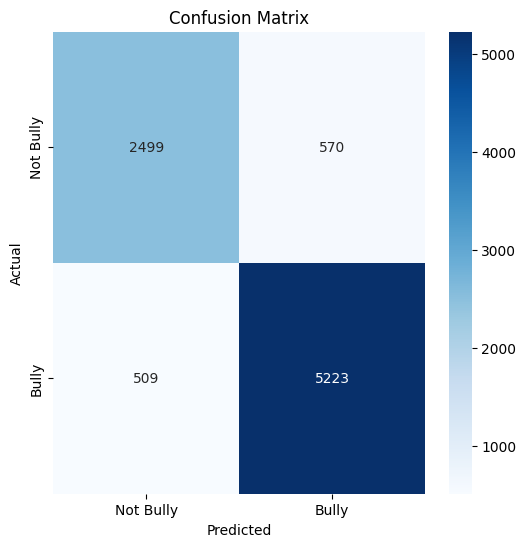

In [ ]:

# Plot Confusion Matrix
def plot_confusion_matrix(labels, preds):

    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Bully", "Bully"], yticklabels=["Not Bully", "Bully"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Display confusion matrix
plot_confusion_matrix(labels, preds)
